In [ ]:
# !pip install ISR -U
# !pip install 'h5py==2.10.0' --force-reinstall
# # restart after installation

In [ ]:
import os
import glob
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
from imageio import imread, imsave
from ISR.models import RDN, RRDN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !pip install kaggle
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d ikarus777/best-artworks-of-all-time 

100% 2.29G/2.29G [00:27<00:00, 31.7MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.5MB/s]


In [ ]:
# !mkdir artworks
# !unzip -q '/content/best-artworks-of-all-time.zip' -d '/content/artworks/'

In [ ]:
df = pd.read_csv('/content/artworks/artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [ ]:
# Most popular genres
df.groupby('genre')['paintings'].sum().sort_values(ascending=False)

genre
Impressionism                              1370
Post-Impressionism                         1048
Northern Renaissance                        680
Baroque                                     586
Cubism                                      439
Romanticism                                 388
Symbolism,Post-Impressionism                311
Primitivism                                 309
High Renaissance                            301
Impressionism,Post-Impressionism            277
High Renaissance,Mannerism                  255
Surrealism                                  241
Surrealism,Impressionism                    194
Expressionism                               193
Expressionism,Abstractionism,Surrealism     188
Pop Art                                     181
Symbolism                                   171
Early Renaissance                           164
Suprematism                                 126
Primitivism,Surrealism                      120
Proto Renaissance                 

In [ ]:
# Saving artists with genres 'Impressionism' and 'Post-Impressionism'
artist = df[(df['genre'] == 'Impressionism') | (df['genre'] == 'Post-Impressionism')]['name'].tolist()

In [ ]:
artistlist = []
for i in artist:
  artistlist.append(i.replace(' ', '_'))
artistlist

['Claude_Monet',
 'Vincent_van_Gogh',
 'Pierre-Auguste_Renoir',
 'Alfred_Sisley',
 'Edgar_Degas',
 'Henri_de_Toulouse-Lautrec',
 'Paul_Cezanne',
 'Georges_Seurat']

In [ ]:
!mkdir /content/Dataset_art

In [ ]:
# Copying their works to a new directory
for i in artistlist:
  os.chdir('/content/artworks/images/images/'+i)
  dst_dir = '/content/Dataset_art/'
  for f in os.listdir():
    shutil.copy(f, dst_dir)

In [ ]:
# Checking for greyscale images (with only one channel)
os.chdir('/content/Dataset_art/')
for filename in os.listdir():
  image = imread(filename)
  if(len(image.shape)<3):
        print(filename)

Alfred_Sisley_199.jpg


In [ ]:
# Deleting them
!rm /content/Dataset_art/Alfred_Sisley_199.jpg

In [ ]:
# Preparing our images for dataloader

In [ ]:
class Arts(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(main_dir)
    def __len__(self):
        return len(self.total_imgs)
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
image_size = 64 # resizing all images to 64*64
batch_size = 64
latent_size = 128 # 'noise' shape for generator
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # normalizes the image in the range [-1, 1]

transform = tt.Compose([tt.Resize((image_size, image_size)),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])

In [ ]:
arts = Arts('/content/Dataset_art', transform)

In [ ]:
train_dl = DataLoader(arts, batch_size, shuffle=True, pin_memory=True)

In [ ]:
# Function to get images back in original range [0, 1]
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(batch):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(batch.detach()[:64]), nrow=8).permute(1, 2, 0))

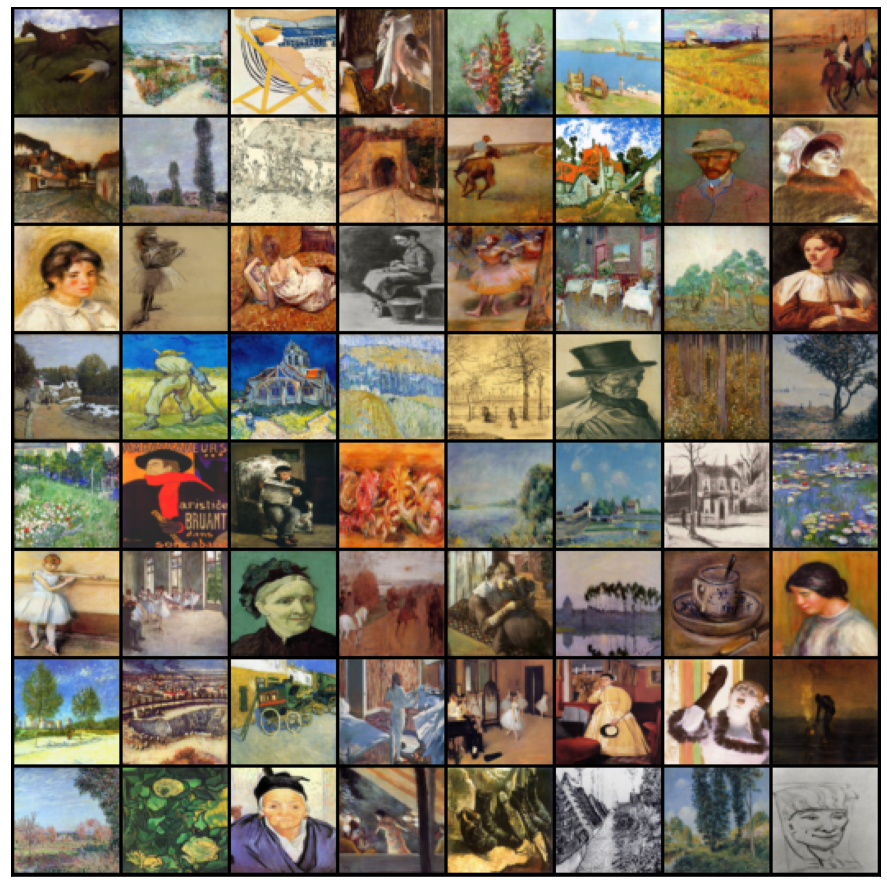

In [ ]:
# Original images
show_images(next(iter(train_dl)))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid())
    def forward(self, x):
        output = self.layer(x)
        return output
discriminator = Discriminator().to(device)
summary(discriminator, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer =  nn.Sequential(
            # in: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh())
            # out: 3 x 64 x 64
    def forward(self, x):
        output = self.layer(x)
        return output
generator = Generator().to(device)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    # Pass real images through discriminator
    real_preds = discriminator(real_images).to(device) #real images
    real_targets = torch.ones(real_images.size(0), 1).to(device) #setting targets as 1
    real_loss = F.binary_cross_entropy(real_preds, real_targets) #getting the loss
    real_score = torch.mean(real_preds).item()
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1).to(device) #generating the random noices for input image
    fake_images = generator(latent).to(device)  #getting the fake images
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1).to(device) #setting 0 as target for fake images
    fake_preds = discriminator(fake_images).to(device)  #getting the predictions for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  #Comparing the two scores through loss
    fake_score = torch.mean(fake_preds).item()
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    # Update generator weights
    loss.backward()
    opt_g.step()
    return loss.item(), latent

In [ ]:
#To save the generated images produced during epochs
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors).to(device)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))

In [ ]:
# New directories for saving D and G
!mkdir saved_d
!mkdir saved_g

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    for epoch in range(epochs):
        for real_images in tqdm(train_dl):
            real_images= real_images.to(device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g, latent = train_generator(opt_g)
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        # Saving generated images
        save_samples(epoch+start_idx, latent, show=False)
        # Saving models
        if epoch % 15 == 0:
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': opt_d.state_dict()}, f'/content/Dataset_art/saved_d/disc{epoch+1}.pth')
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': opt_g.state_dict()}, f'/content/Dataset_art/saved_g/gen{epoch+1}.pth')
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(epochs=150, lr=0.001)

In [ ]:
# Function for cropping and saving generated images
def cropped(original_image_path, folder_name): #folder_name - new folder for cropped images
  os.mkdir(f'/content/Dataset_art/{folder_name}')
  im = Image.open(original_image_path)
  cropped_image_size = 64
  batch_size = 64
  frame_width = 2 # width of a frame around each image
  left = 1 # setting starting coordinates
  top = 1 # setting starting coordinates
  right = left + cropped_image_size + frame_width # setting starting coordinates
  bottom = top + cropped_image_size  + frame_width# setting starting coordinates
  index = 1
  for i in range(batch_size):
      if right < im.size[0]:
          img = im.crop((left, top, right, bottom))
          name = 'image-{0:0=4d}.png'.format(index)
          left += cropped_image_size + frame_width
          right += cropped_image_size + frame_width
          top = top
          bottom= bottom
      if right >= im.size[0]:
          left = 1
          top += cropped_image_size + frame_width
          right = left + cropped_image_size + frame_width
          bottom = top + cropped_image_size + frame_width
      index += 1
      img.save(f'/content/Dataset_art/{folder_name}/'+ name, 'PNG')

In [ ]:
# Cropping and saving some images
cropped('/content/Dataset_art/generated/generated-images-0132.png', 'cropped132')
cropped('/content/Dataset_art/generated/generated-images-0140.png', 'cropped140')
cropped('/content/Dataset_art/generated/generated-images-0141.png', 'cropped141')
cropped('/content/Dataset_art/generated/generated-images-0142.png', 'cropped142')
cropped('/content/Dataset_art/generated/generated-images-0147.png', 'cropped147')
cropped('/content/Dataset_art/generated/generated-images-0148.png', 'cropped148')
cropped('/content/Dataset_art/generated/generated-images-0150.png', 'cropped150')

In [ ]:
# Move your favorite cropped images to this folder
!mkdir '/content/Dataset_art/best_arts'

In [ ]:
!mv '/content/Dataset_art/cropped132/image-0006.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped132/image-0058.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped132/image-0010.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped132/image-0011.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped132/image-0033.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped140/image-0057.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped140/image-0059.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped142/image-0003.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped142/image-0004.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped147/image-0060.png' '/content/Dataset_art/cropped147/image-human.png'
!mv '/content/Dataset_art/cropped147/image-human.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped148/image-0026.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped148/image-0036.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped150/image-0025.png' '/content/Dataset_art/best_arts'
!mv '/content/Dataset_art/cropped150/image-0060.png' '/content/Dataset_art/best_arts'

In [ ]:
# Trying ISR for some of them

In [ ]:
def RDN_func(image_path):
    rdn = RDN(weights='noise-cancel')

    image = Image.open(image_path)
    display(image)

    first = rdn.predict(np.array(image))
#   first = Image.fromarray(first)

    second = rdn.predict(np.array(first))
#   second = Image.fromarray(second)

    third = rdn.predict(np.array(second))
#   third = Image.fromarray(third)

    display(Image.fromarray(third))
    return image, third

In [ ]:
def RRDN_func(image_path):
    rdn = RRDN(weights='gans')

    image = Image.open(image_path)

    first = rdn.predict(np.array(image))
#   first = Image.fromarray(first)
  
    second = rdn.predict(np.array(first))
#   second = Image.fromarray(second)

    display(Image.fromarray(second))
    return second

In [ ]:
for file in os.listdir('/content/Dataset_art/best_arts'):
    RDN_func('/content/Dataset_art/best_arts/' + file)
    RRDN_func('/content/Dataset_art/best_arts/' + file)
